# Binary classification using Transfer  + Fixed Dataset

In [1]:
# import the required libraries
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import DirectoryIterator
from keras.callbacks import ModelCheckpoint

In [2]:
# Checking for GPU
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# To re-size all the images to (224, 224)
IMAGE_SIZE = [224, 224]

In [4]:
# Enter file paths for train, validation and test set
train_path = 'distracted_driver/train'
valid_path = 'distracted_driver/val'
test_path = 'distracted_driver/test'

In [5]:
# Enter one sample test image path for final prediction
sample_test_distracted = 'distracted_driver/test/Distracted/img_568.jpg'
sample_test_focused = 'distracted_driver/test/Focused/img_3570.jpg'

In [6]:
# Adding preprocessing layer to the beginning of VGG16
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Adding preprocessing layer to the beginning of ResNet50
resnet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
def transfer_learning(arch, train_path, valid_path):
    
    # Freezing hidden layers
    for layer in arch.layers:
        layer.trainable = False

    # To get number of classes
    num_folders = glob(train_path + '/*')
    num_classes = len(num_folders)

    # Flatten the VGG/ResNet output and pass it through 2 Dense layers
    x = Flatten()(arch.output)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    prediction = Dense(2, activation='softmax')(x)

    # Initialize a model object
    model = Model(inputs=arch.input, outputs=prediction)

    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       shear_range = 0.2, 
                                       zoom_range = 0.2, 
                                       horizontal_flip = False)

    val_datagen = ImageDataGenerator(rescale = 1./255)

    print("For train set: ")
    train_set = train_datagen.flow_from_directory(train_path, 
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  class_mode = 'categorical')
    
    print("\nFor validation set: ")
    val_set = val_datagen.flow_from_directory(valid_path,
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical')
    
    # fit the model
    print(f"\nFitting the model...")
    r = model.fit(train_set, 
                  validation_data=val_set, 
                  epochs=5, 
                  steps_per_epoch=len(train_set), 
                  validation_steps=len(val_set))
    return model, r

In [8]:
def loss_acc_plots(r):
    # loss
    epochs = np.arange(1,6)
    plt.figure(figsize=(5, 4), dpi=100)
    plt.plot(epochs, r.history['loss'], label='Train loss')
    plt.plot(epochs, r.history['val_loss'], label='Validation loss')
    plt.title("Train and Validation Loss for every epoch")
    plt.xticks(epochs)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.show();
    
    # accuracies
    plt.figure(figsize=(5, 4), dpi=100)
    plt.plot(epochs, r.history['accuracy'], label='Train accuracy')
    plt.plot(epochs, r.history['val_accuracy'], label='Validation accuracy')
    plt.title("Train and Validation accuracy for every epoch")
    plt.xticks(epochs)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.show();

In [9]:
def get_predictions_and_acc(model, test_path):

    y_pred = [] # Stores predicted class
    
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_set = test_datagen.flow_from_directory(test_path,
                                                target_size = (224, 224),
                                                shuffle=False,
                                                class_mode = 'categorical')
    preds = model.predict(test_set)
    
    for i in preds:
        y_pred.append(np.argmax(i))
        
    # Finding accuracy using sklearn    
    acc = accuracy_score(y_pred, list(test_set.labels))

    return y_pred, acc

In [10]:
def show_sample_img(sample_test):
    image = mpimg.imread(sample_test)
    plt.figure(figsize=(5, 4), dpi=100)
    plt.imshow(image)
    plt.title("Sample test image BEFORE reshaping")
    plt.show();

    #load the image
    my_image = load_img(sample_test, target_size=(224, 224))
    plt.figure(figsize=(5, 4), dpi=100)
    plt.imshow(my_image)
    plt.title("Sample test image AFTER reshaping")
    plt.show();

In [11]:
def sample_predict(model, sample_test): 
    
    #preprocess the image
    my_image = load_img(sample_test, target_size=(224, 224))
    my_image = img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    my_image = preprocess_input(my_image)

    a = np.argmax(model.predict(my_image))

    if a == 0:
        pred = "Distracted"
    else:
        pred = "Focused"
        
    return pred

## 1) Using VGG16

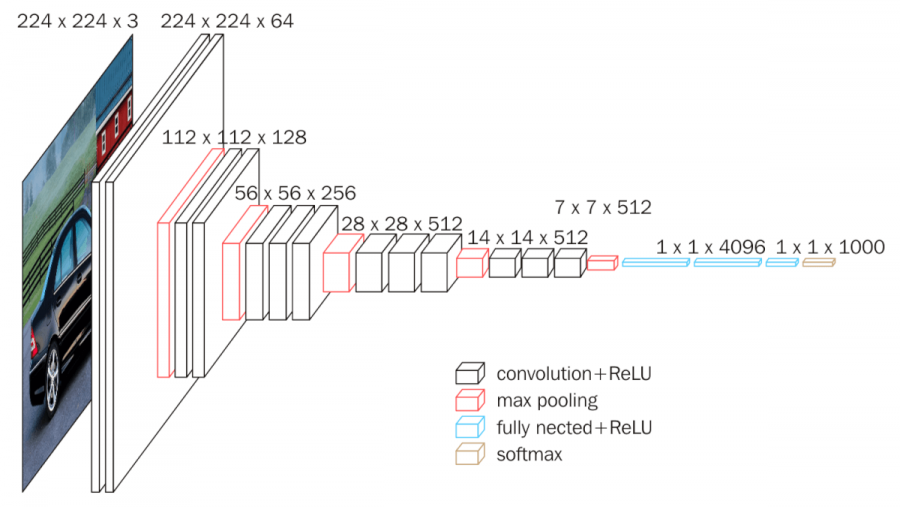

In [12]:
model, r = transfer_learning(vgg, train_path, valid_path)

For train set: 
Found 15585 images belonging to 2 classes.

For validation set: 
Found 3540 images belonging to 2 classes.

Fitting the model...
Epoch 1/5
488/488 [==============================] - 255s 507ms/step - loss: 0.3060 - accuracy: 0.8737 - val_loss: 0.7978 - val_accuracy: 0.7483
Epoch 2/5
488/488 [==============================] - 250s 511ms/step - loss: 0.0830 - accuracy: 0.9693 - val_loss: 0.9196 - val_accuracy: 0.7573
Epoch 3/5
488/488 [==============================] - 217s 444ms/step - loss: 0.0717 - accuracy: 0.9742 - val_loss: 1.4384 - val_accuracy: 0.7042
Epoch 4/5
488/488 [==============================] - 218s 447ms/step - loss: 0.0527 - accuracy: 0.9801 - val_loss: 2.1846 - val_accuracy: 0.6732
Epoch 5/5
488/488 [==============================] - 216s 443ms/step - loss: 0.0442 - accuracy: 0.9839 - val_loss: 2.8423 - val_accuracy: 0.6636


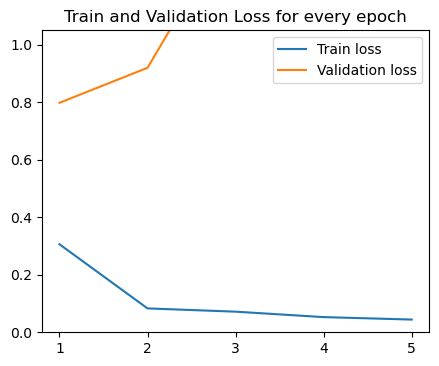

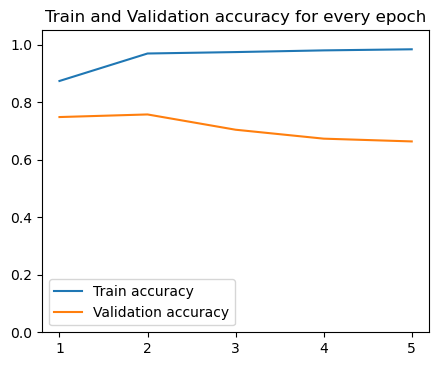

In [13]:
loss_acc_plots(r)

In [14]:
y_pred_vgg, acc_vgg = get_predictions_and_acc(model, test_path)

Found 3299 images belonging to 2 classes.


In [15]:
print(f'Final accuracy using pre-trained VGG16 architecture = {round(acc_vgg*100, 2)} %' )

Final accuracy using pre-trained VGG16 architecture = 46.38 %


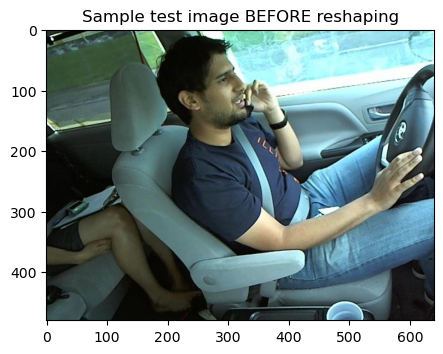

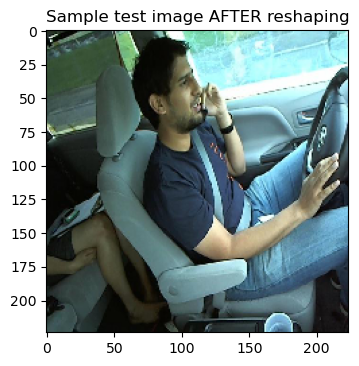

In [16]:
show_sample_img(sample_test_distracted)

In [17]:
print("Predicted class of the sample test image: ", sample_predict(model, sample_test_distracted))

Predicted class of the sample test image:  Focused


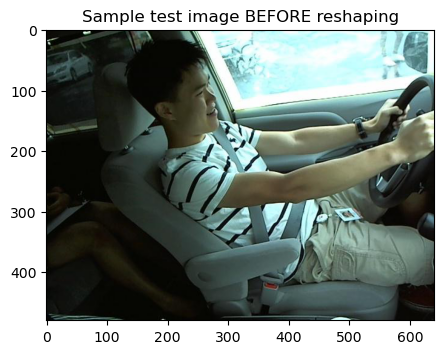

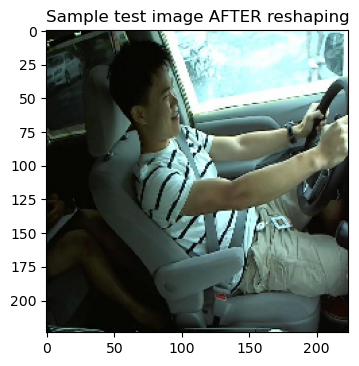

In [18]:
show_sample_img(sample_test_focused)

In [19]:
print("Predicted class of the sample test image: ", sample_predict(model, sample_test_focused))

Predicted class of the sample test image:  Focused


## 2) Using ResNet50

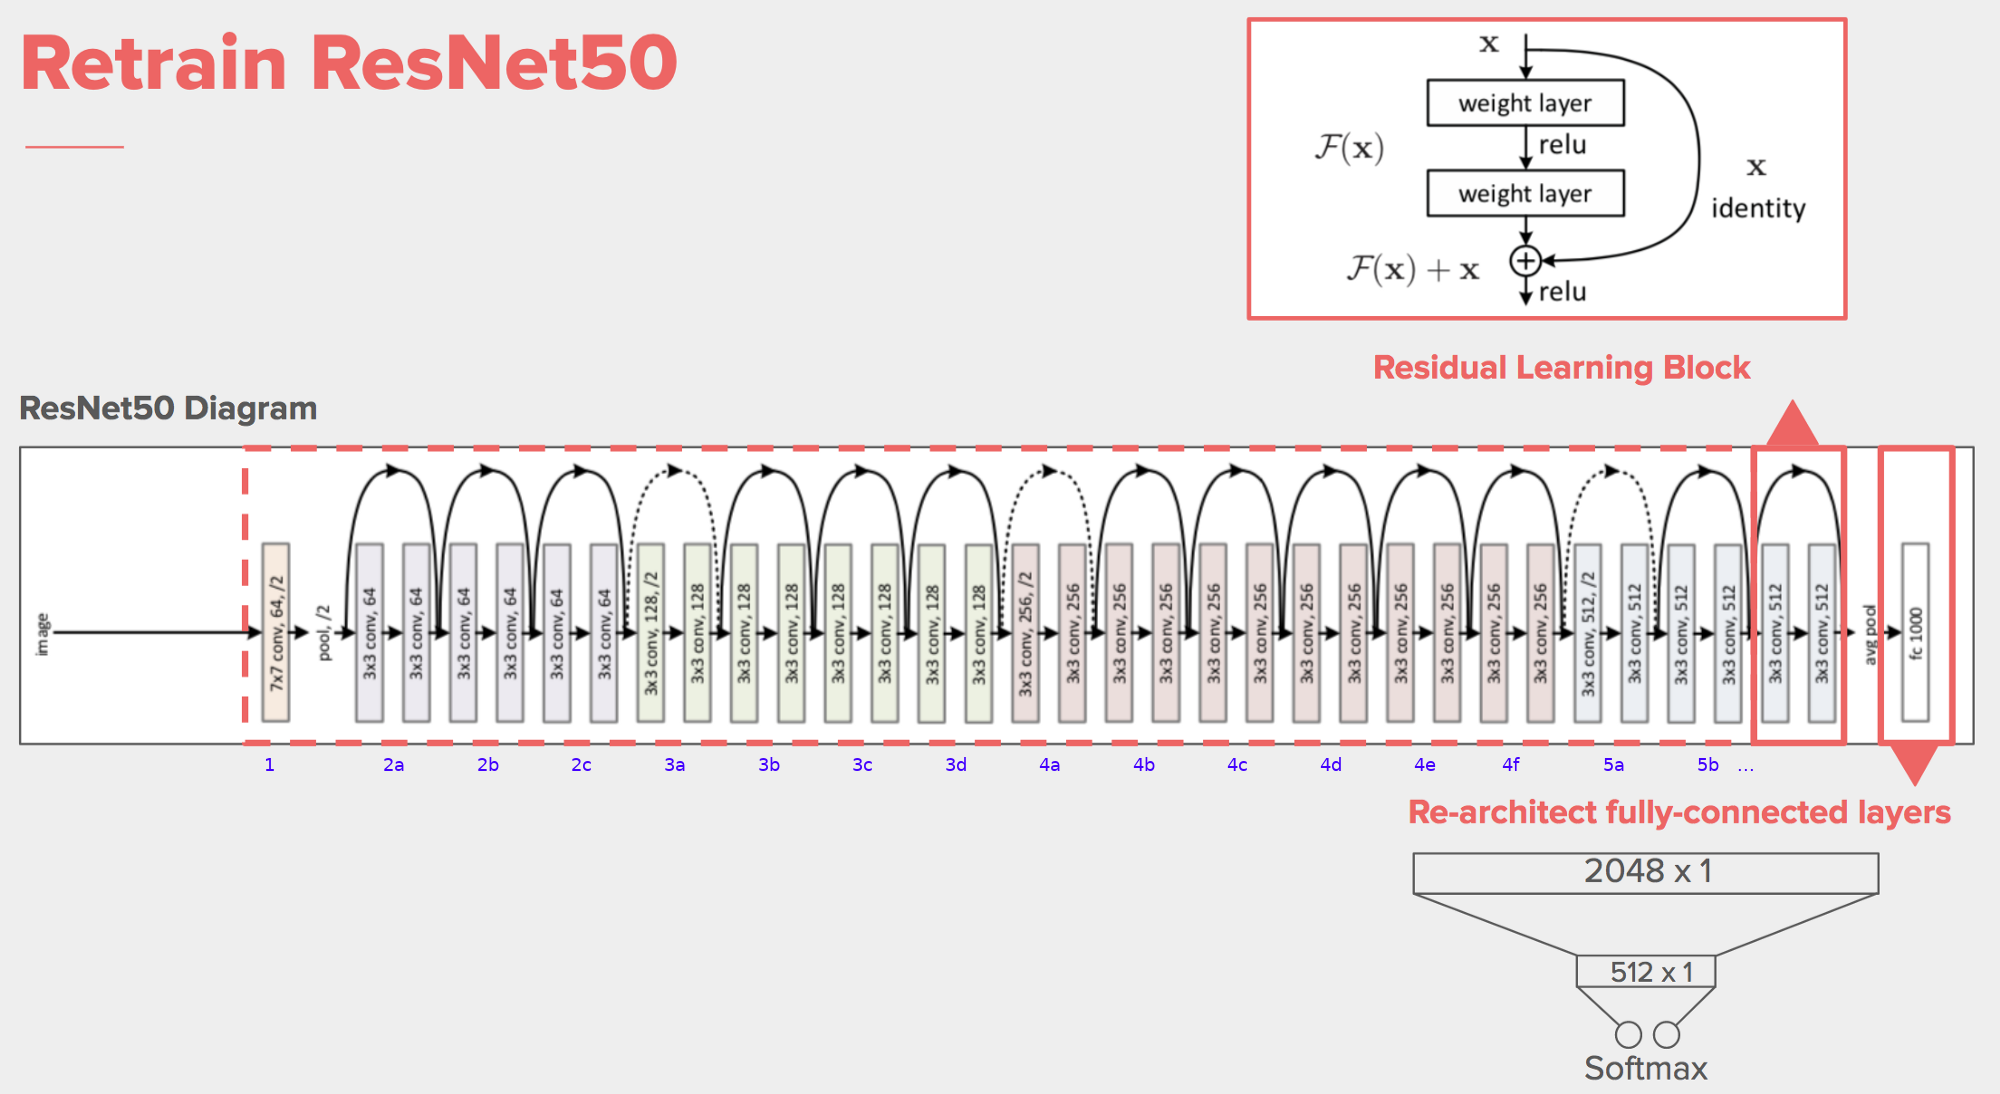

In [20]:
model_resnet, r_resnet = transfer_learning(resnet50, train_path, valid_path)

For train set: 
Found 15585 images belonging to 2 classes.

For validation set: 
Found 3540 images belonging to 2 classes.

Fitting the model...
Epoch 1/5
488/488 [==============================] - 212s 429ms/step - loss: 0.7659 - accuracy: 0.6382 - val_loss: 0.7655 - val_accuracy: 0.5073
Epoch 2/5
488/488 [==============================] - 211s 431ms/step - loss: 0.5193 - accuracy: 0.7380 - val_loss: 0.8251 - val_accuracy: 0.5373
Epoch 3/5
488/488 [==============================] - 230s 471ms/step - loss: 0.4321 - accuracy: 0.8013 - val_loss: 0.8513 - val_accuracy: 0.5715
Epoch 4/5
488/488 [==============================] - 223s 457ms/step - loss: 0.3862 - accuracy: 0.8262 - val_loss: 0.8168 - val_accuracy: 0.5842
Epoch 5/5
488/488 [==============================] - 217s 444ms/step - loss: 0.3702 - accuracy: 0.8352 - val_loss: 1.0565 - val_accuracy: 0.5582


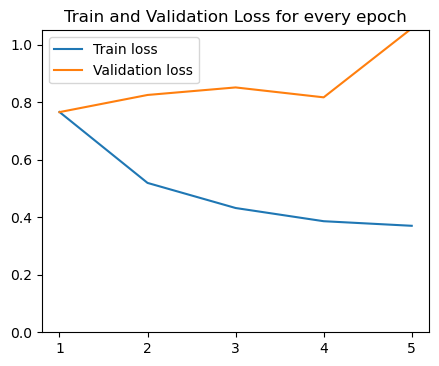

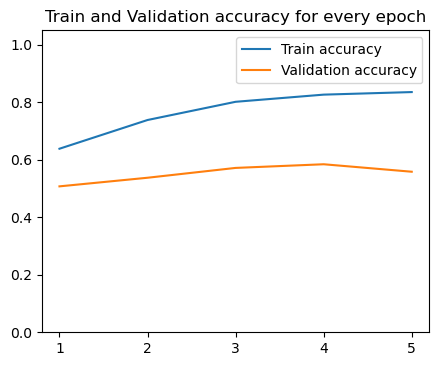

In [21]:
loss_acc_plots(r_resnet)

In [22]:
y_pred_resnet, acc_resnet = get_predictions_and_acc(model_resnet, test_path)

Found 3299 images belonging to 2 classes.


In [23]:
print(f'Final accuracy using pre-trained ResNet50 architecture = {round(acc_resnet*100, 2)} %' )

Final accuracy using pre-trained ResNet50 architecture = 48.98 %


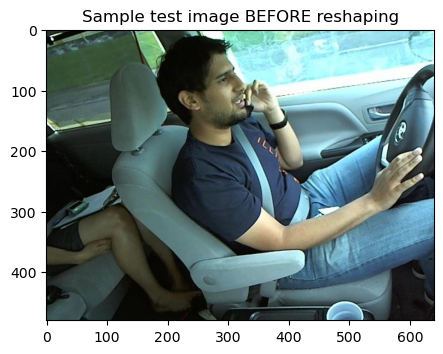

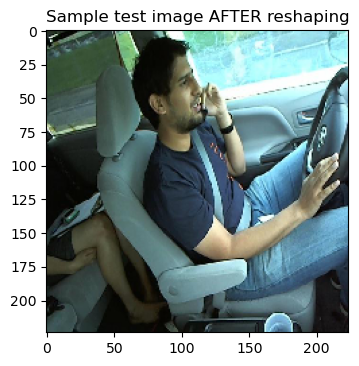

In [24]:
show_sample_img(sample_test_distracted)

In [25]:
print("Predicted class of the sample test image: ", sample_predict(model_resnet, sample_test_distracted))

Predicted class of the sample test image:  Focused


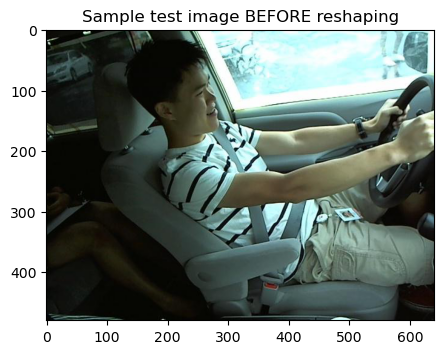

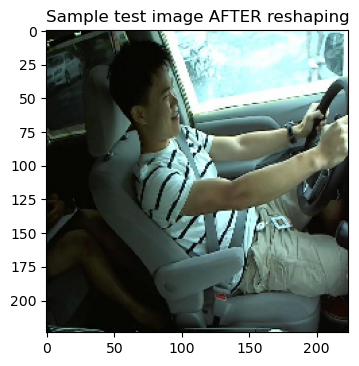

In [26]:
show_sample_img(sample_test_focused)

In [27]:
print("Predicted class of the sample test image: ", sample_predict(model_resnet, sample_test_focused))

Predicted class of the sample test image:  Focused
